# Reinforcement Learning: Bandits

In [87]:
import numpy as np
import matplotlib.pyplot as plt

## Problem

Reinforcement learning is learning optimal behaviour in a sequential environment through reinforcement signals from the environment. The simplest class of RL problems is the [$k$-armed bandit problems](https://en.wikipedia.org/wiki/Multi-armed_bandit), where you are repeatedly faced with a choice among $k$-different actions which all produce a reward chosen from a probability distribution. This probability distribution can be stationary or non-stationary, and we will explore both. 

In [88]:
class KArmedBanditEnv:
    def __init__(self, k, stationary=True):
        self.k = k
        self.stationary = stationary
        self.action_space = np.arange(k)
        self.true_q_values = np.random.normal(0, 1, k)
        
    def get_reward(self, action):
        if not self.stationary:
            # Non-stationary: Update true q-values over time
            self.true_q_values += np.random.normal(0, 0.01, self.k)
        return np.random.normal(self.true_q_values[action], 1)

## Policy

The strategy an RL agent employs to select actions is know as the policy. 
A greedy policy is always selecting the optimal action in every setting. 
However, we might not always know what the greedy policy is, therefore we might need to test actions at random to get a feel for how good each action is. 
Additionally, if the underlying distribution of the problem is non-stationary, we need to constantly adapt the policy to maximize returns. 
A central problem in reinforcement learning is balancing exploring unkown territory and exploiting current knowledge in what is known as the exploration-exploitation tradeoff. 
A simple way of dealing with this tradeoff is using the $\epsilon$-greedy policy, which works as follows: 
$$ a_t = \begin{cases}
             \argmax_a Q(a)  & \text{with probability } \epsilon \in [0,1] \\
             a\ random\ action  & \text{with probability } 1-\epsilon \in [0,1] \ge 0
       \end{cases} $$

It is common to decay the $\epsilon$ so that the epsilon greedy policy converges to the greedy policy, especially fro stationary problems. 

In [89]:
def epsilon_greedy(Q, epsilon):
    if np.random.rand() < epsilon:
        return np.random.choice(len(Q))
    else:
        return np.argmax(Q)

Another slightly more advanced policy is the Upper-Confidence-Bound action selection.
It selects actions based on a combination of their estimated value and an exploration term that encourages exploration of less-explored actions. The UCB formula typically like:

$$ a_t = \argmax_a \left( Q_t(a) + c \sqrt{\dfrac{\ln t}{N_t (a)}} \right) $$

In [162]:
def ucb_action(Q, N, t, c=2):
    exploration_term = c * np.sqrt(np.log(t) / (N + 1e-5))  # Adding a small constant to avoid division by zero
    return np.argmax(Q + exploration_term)

## Training loop

After each action $a_t$ you recieve a numerical reward $r_t \in \mathbb{R}$ chosen from a stationary probability distribution that depends on the action you selected. Your objective is to maximize the expected returns over an episode $\mathbb{E}[G]$, $G = \sum_{i=1}^n r_i$. 

In order to achieve this objective we need some way of estimating the values of actions, also known as an action-value function. One natural way of estimating this is by averaging the rewards actually recieved (the sample-average method): 
$$ Q_t (a) = \dfrac{sum\ of\ rewards\ when\ a\ taken\ prior\ to\ t}{number\ of\ times\ a\ taken\ prior\ to\ t} = \dfrac{\sum_{i=1}^{t-1}r_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1} \mathbb{1}_{A_i=a}} $$ 

Lets just focus on one action. Let $r_t$ denote the reward revieved after the $i$th selection of this action, and let $Q_n$ denote the estimate of its action value after it has been selected $n-1$ times, which we now write as: 
$$ Q_n = \dfrac{r_1 + r_2 +... + r_{n-1}}{n-1} $$
This implementation would require computational and memory requirements that would grow linearly with time. 

A simple and more efficient way to compute this is: 
$$ Q_{n+1} = Q_n + \dfrac{(r_n - Q_n) }{n} $$

Averaging the Q-values is appropriate if the problem is stationary. However, for non-stationary bandit problems we use a learning rate $\alpha \in (0,1]$ to give more weight to recent rewards than to long-past rewards
$$ Q_{n+1} = Q_n + \alpha (r_n - Q_n) $$
Which makes $Q_{n+1}$ a weighted average of past rewards and the initial estimate $Q_1$. We also see that if $\alpha=1$ then $Q_{n+1}=r_n$. 

The Q-values are typically initialized to 0, but as we will see later, we can also modify the initial Q-values to help us solve the exploration-exploitation dilemma. 

In [167]:
def train_bandit(env, num_steps, epsilon, decay_rate=1, q_init=0, learning_rate=1, ucb=False, c=2):
    Q = np.ones(env.k) * q_init  # Action values
    N = np.zeros(env.k)  # Action counts
    rewards = np.zeros((num_steps,))
    optimal_actions = np.zeros(num_steps)  # Track optimal actions

    for step in range(num_steps):
        if ucb:
            action = ucb_action(Q, N, step+1, c)
        else:
            action = epsilon_greedy(Q, epsilon)
        reward = env.get_reward(action)

        N[action] += 1
        if learning_rate==1:
            Q[action] += (reward - Q[action]) / N[action]
        else:
            Q[action] += (learning_rate * ((reward - Q[action])))

        rewards[step] = reward
        optimal_actions[step] = 1 if action == np.argmax(env.true_q_values) else 0
        epsilon*=decay_rate

    return rewards, optimal_actions

We then create a function to test the bandit problem with different parameters and produces a plot which displays the returns. 

In [165]:
def plot_test(epsilon_values=[0.01, 0.2, 0.5], k=10, num_steps=1000, num_runs=200, smoothing_window=10, stationary=True, decay_rate=1, q_init=0, learning_rate=1, ucb=False, c=2):
    plt.figure(figsize=(10, 6))

    for epsilon in epsilon_values:
        #all_rewards = np.zeros((num_runs, num_steps))
        all_optimal_actions = np.zeros((num_runs, num_steps))

        for run in range(num_runs):
            env = KArmedBanditEnv(k, stationary)
            rewards, optimal_actions = train_bandit(env, num_steps, epsilon, decay_rate, q_init, learning_rate, ucb, c)
            #all_rewards[run, :] = rewards
            all_optimal_actions[run, :] = optimal_actions

        #avg_rewards = np.mean(all_rewards, axis=0)
        avg_optimal_actions = np.mean(all_optimal_actions, axis=0)
        #smoothed_rewards = np.convolve(avg_rewards, np.ones(smoothing_window)/smoothing_window, mode='valid')
        smoothed_optimal_actions = np.convolve(avg_optimal_actions, np.ones(smoothing_window)/smoothing_window, mode='valid')
    
        #plt.plot(avg_rewards, label=f'Epsilon = {epsilon}')
        plt.plot(smoothed_optimal_actions * 100, label=f'Epsilon = {epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Percentage of Optimal Actions')
    plt.title(f'{num_runs} Runs of Epsilon-Greedy on {k}-Armed Bandit')
    plt.legend()
    plt.show()

## Test stationary and zero decay

First we test the problem with stationary reward distributions and three different $\epsilon$ values for the policy. 

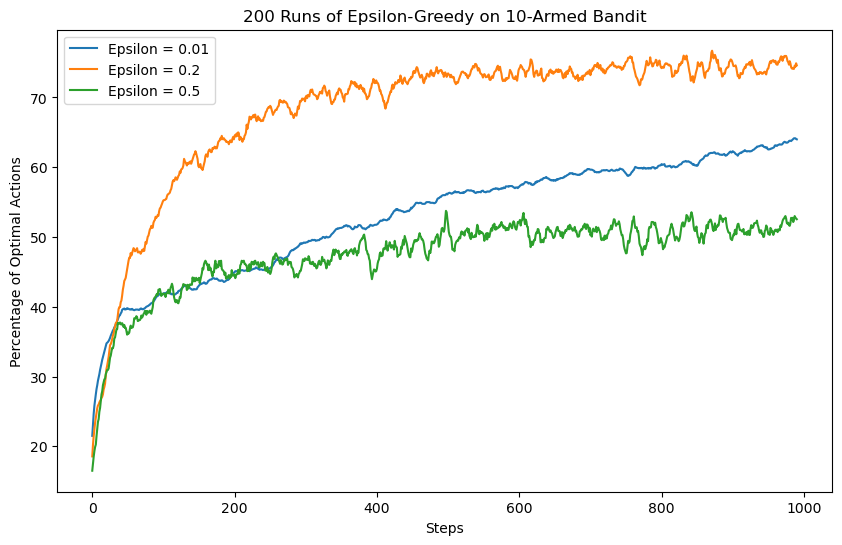

In [139]:
plot_test(stationary=True, decay_rate=1)

## Test stationary and decay

Since this problem is stationary we can explore in the early epochs and gradually decay the exploration rate $\epsilon$ towards 0 using a decay reate $\lambda \in (0,1)$ (i.e., towards the greedy policy). 

In [123]:
decay_rate = 1-1e-2

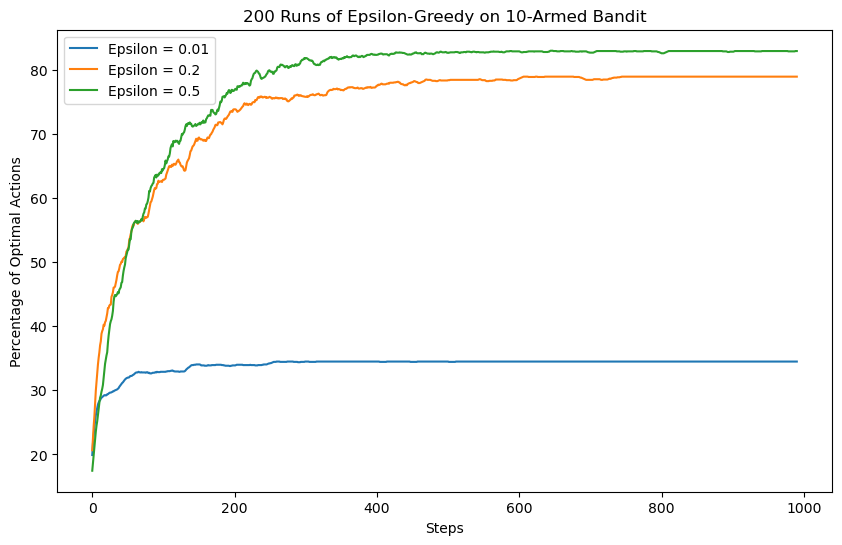

In [124]:
plot_test(stationary=True, decay_rate=decay_rate)

Now we see that the policy with $\epsilon=0.5$ has gone from being the worst policy to being the best. 
The reason for this is that exploring 50\% of the time means that even if the agent is able to figure out the optimal action, it will choose a random action half the time, which gives us an expectation of chosing the optimal action $1/2 * 1 + 1/2 * 1/10 = 11/20$ of the time. 
With a decaying exploration rate it works better as it converges to the greedy policy after having tried all bandits a sufficient number of times. Lower $\epsilon$ values does not explore enough before converging to the greedy policy, so they have to settle for a sub-optimal policy. 

## Test optimistic initial values

Another way of solving the problem of initial exploration vs exploitation in the stationary setting is using optimistic initial values. 
The idea behind optimistic initial values is initializing the Q-values $Q_1$ to high values, higher than what is likely to be the real values, which will incentivice the agent to select those actions in the initial epochs. After having visited those states the agent the slowly lowers the Q-values to the real values, and this guarantees that all actions will be atempted in the limit. 

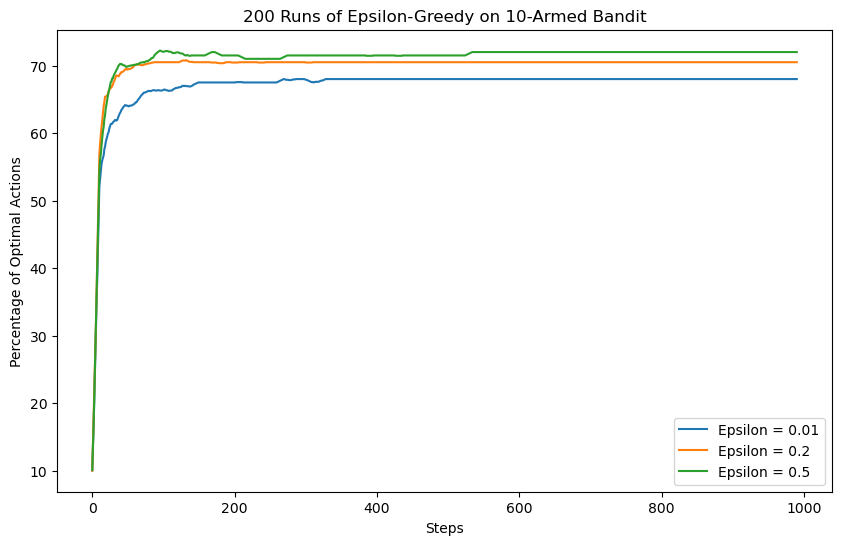

In [135]:
plot_test(stationary=True, decay_rate=0, q_init=5)

## Test non-stationary 

Now we see how the $\epsilon$-greedy policy performs on non-staionary distributions. We start with learning rate $\alpha=1$ which makes $Q_{n+1}=r_n$. 

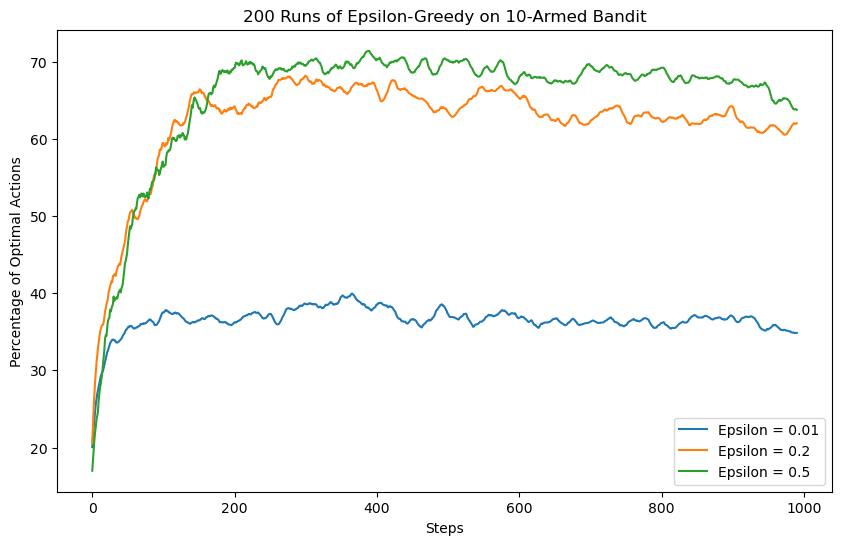

In [161]:
plot_test(stationary=False, decay_rate=decay_rate, learning_rate=1)

However, $\alpha=1$ produces erratic changes in the policy, and a smoother change might be more appropriate with a learning rate of $\alpha=0.1$. 

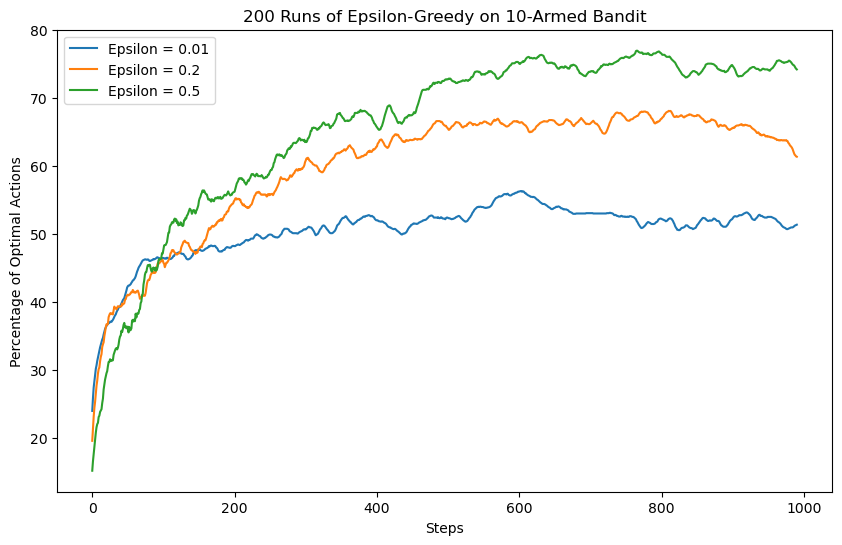

In [160]:
plot_test(stationary=False, decay_rate=decay_rate, learning_rate=0.1)

## Test Upper-Confidence-Bound action selection.

Finally, we are going to test UCB action selection. We see that for both the stationary and non-stationary bandit problems UCB outperformes epsilon greedy action selection. 

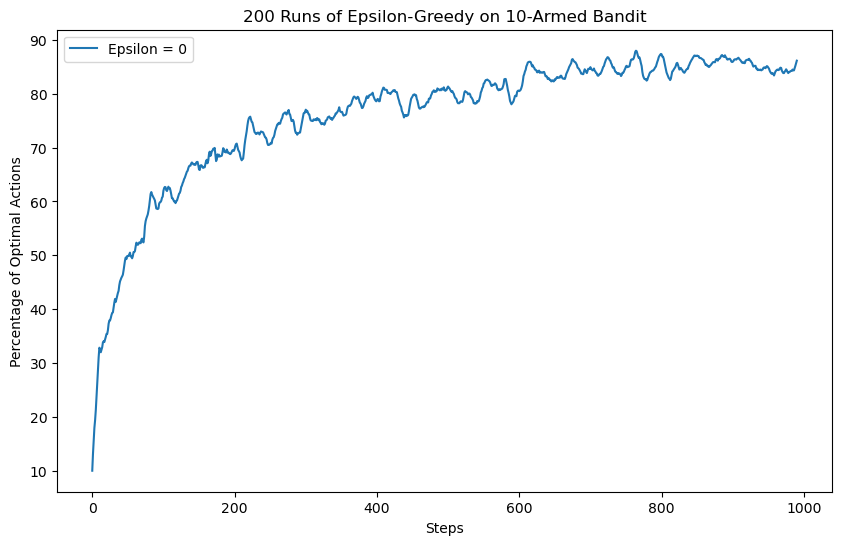

In [170]:
plot_test(stationary=True, ucb=True, c=2, epsilon_values=[0])

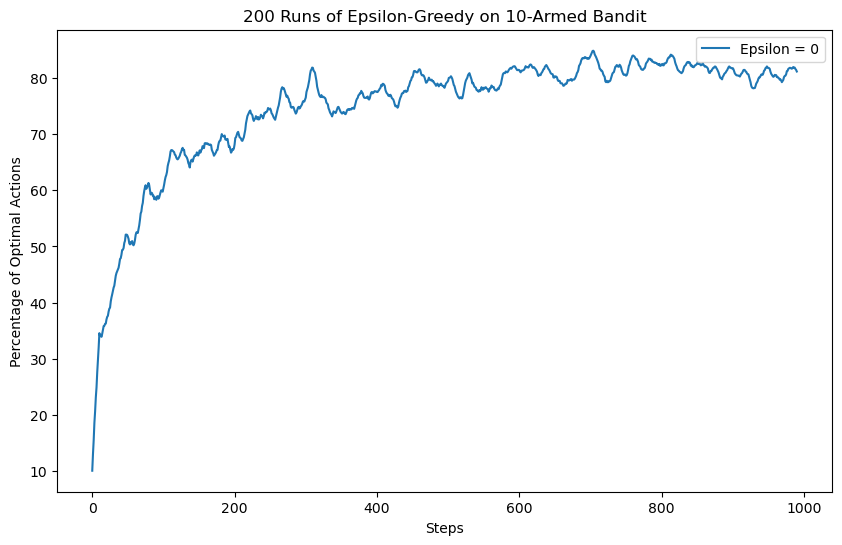

In [173]:
plot_test(stationary=False, ucb=True, c=2, epsilon_values=[0])